# Partinioning Around Medioids (PAM)

## Implementación

In [32]:
!pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pandas as pd
import random
import copy
from haversine import haversine

# Función para calcular distancia (disimilaridad) entre cada finca y los medioids iniciales
def disimilaridadFincaMedioids(fincas, medioids):
  dictDist = {}
  dictAsign = {}
  for fincaAct in fincas:
    if fincaAct not in medioids:
      dictDist[fincaAct] = []
      for medioidAct in medioids:
        if haversine(fincaAct, medioidAct) != 0: # Agrega fincas sin contar el medioid actual
          dictDist[fincaAct].append(haversine(fincaAct, medioidAct))
        dictAsign[medioidAct] = [[], []]
  return dictDist, dictAsign

# Función para asignar cada finca al medioid más cercano con disponibilidad de fincas y la distancia de cada medioid a las fincas
def asignarFincasMedioid(fincas, medioids, dictDist, dictAsign):
  for fincaAct in fincas:
    if fincaAct not in medioids:
      numFincas = len(fincas)
      nMedioids = len(medioids)
      tope = (numFincas // nMedioids) - 2 # El máximo de fincas que no debería superar cada cluster
      posicionesKSirven = []
      for llave in list(dictAsign.keys()):
        if len(dictAsign[llave][0]) <= tope:
          posicionesKSirven.append(medioids.index(llave)) # Posiciones de medioids que respetan el tope
      listaDistAct = dictDist[fincaAct] # Lista de distancias de la finca a cada medioid
      if len(posicionesKSirven) > 0:
        for i in range(len(listaDistAct)):
          if i not in posicionesKSirven:
            listaDistAct[i] = 70000
      minimoAct = min(listaDistAct) # El medioid más cercano a la finca actual
      posiMedioid = listaDistAct.index(minimoAct) # Argmin de la línea anterior
      posiFinca = fincas.index(fincaAct) # Número de la finca actual
      dictAsign[medioids[posiMedioid]][0].append(minimoAct) # Agregar la distancia de la finca agregada
      dictAsign[medioids[posiMedioid]][1].append(posiFinca) # Agregar finca al medioid
  return dictAsign

# Función para eliminar un medioid en caso de que quede sin fincas
def eliminarMedioid(dictAsign):
  for medioidAct in list(dictAsign.keys()):
    listaFincasAct = dictAsign[medioidAct][1]
    if len(listaFincasAct) == 0:
      del dictAsign[medioidAct]
  return dictAsign

# Función para calcular costo total
def costoTotal(dictAsign):
  costoActual = 0
  for llave in list(dictAsign.keys()):
    costoActual += sum(dictAsign[llave][0])
  return costoActual

# Función del Swap
def swapFunction(fincas, dictAsign):
  dictAsignAct = copy.deepcopy(dictAsign)
  # Recorrer cada cluster e intercambiar una finca propia de este con cada medioid actual 
  for medioidAct in list(dictAsign.keys()):
    listaFincasAct = dictAsign[medioidAct][1] # Lista de fincas en cada cluster
    # Asegurarse que el medioid y la finca elegida no sean iguales
    termino = False
    fincaRand = listaFincasAct[random.randrange(len(listaFincasAct))] # Selección de una nueva finca como medioid
    while termino == False:
      if fincas[fincaRand] != medioidAct:
        termino = True
      else:
        fincaRand = listaFincasAct[random.randrange(len(listaFincasAct))] # Selección de una nueva finca como medioid
    dictAsignAct[fincas[fincaRand]] = dictAsignAct[medioidAct] 
    del(dictAsignAct[medioidAct]) # Reemplazar el medioid actual por una finca del cluster
    dictAsignAct[fincas[fincaRand]][1].append(fincas.index(medioidAct)) # Guardar el medioid antiguo como finca
  return dictAsignAct

# Función que calcula la cohesión de cada observación (a(i))
def cohesion(dictAsign):
  vectA = []
  for llave in list(dictAsign.keys()):
    listaFincasAct = dictAsign[llave][1] # Lista de las fincas asignadas al cluster actual
    nFincas = len(listaFincasAct) - 1 # Cantidad de fincas para promediar la distancia (sin contar la actual)
    if nFincas > 0:
      for fincaAct in listaFincasAct: # Doble recorrido para calcular distancia entre cada finca y el resto en el cluster
        sumaDistancias = 0
        for finca in listaFincasAct:
          sumaDistancias += haversine(ubFincas[fincaAct], ubFincas[finca])
        promedioDist = sumaDistancias / nFincas # Promediar la distancia de cada finca a las demás 
        vectA.append((fincaAct, promedioDist))
  return vectA

# Función que calcula el valor de la separación (b(i))
def separacion(dictAsign):
  vectB = []
  for llave in list(dictAsign.keys()):
    listaFincasAct = dictAsign[llave][1] # Lista de las fincas asignadas al cluster actual
    for fincaAct in listaFincasAct: # Finca actual evaluada en relación con las demás de los away clusters
      listaPromedios = []
      for llave2 in list(dictAsign.keys()): # Recorrer los otros clusters formados
        if llave != llave2:
          sumaDistanciasCluster = 0 
          listaFincasAwayCluster = dictAsign[llave2][1] # Lista de las fincas asignadas a cada cluster diferente al actual
          nFincas = len(listaFincasAwayCluster) # Cantidad de fincas para promediar la distancia en el away cluster
          for finca in listaFincasAwayCluster:
            sumaDistanciasCluster += haversine(ubFincas[fincaAct], ubFincas[finca])
          promedioDistCluster = sumaDistanciasCluster / nFincas # Promediar la distancia de cada finca a las demás 
          listaPromedios.append(promedioDistCluster) # Agregar el promedio de distancia de la finca actual a las fincas en el away cluster
      # Se guarda el mínimo de promedios entre la finca actual y los away clusters evaluados
      vectB.append((fincaAct, min(listaPromedios)))
  return vectB


In [34]:
# Cargar Datos
coord_df = pd.read_excel('Coordenadas.xlsx', sheet_name = 'Hoja1')
produccion = pd.read_excel('Produccion.xlsx', sheet_name = 'Hoja1')

# Lista con la ubicación de cada Finca
n = 180
lats = list(coord_df['Latitud'])
longs = list(coord_df['Longitud'])
ubFincas = []
for j in range(n):
  ubFincas.append((lats[j], longs[j]))

# =================================================================== #
#============================ FASE BUILD ============================ #
# =================================================================== #
# Definir cantidad de clusters y los medioids iniciales
K = 15
medioidsIniciales = [] # Asignar de forma aleatoria los K medioids a fincas existentes
dictAsignFincasMedioids = {} # Guarda las fincas asignadas a cada medioid
listaRand = random.sample(range(n), K)
for aleAct in listaRand:
  medioidsIniciales.append(ubFincas[aleAct])
# Calcular distancia (disimilaridad) entre cada finca y los medioids iniciales
dictDistFincasMedioids, dictAsignFincasMedioids = disimilaridadFincaMedioids(ubFincas, medioidsIniciales)
# Asignar cada finca al medioid más cercano y calcular el costo (distancia) total
dictAsignFincasMedioids = asignarFincasMedioid(ubFincas, medioidsIniciales, dictDistFincasMedioids, dictAsignFincasMedioids)
# Si un medioid se queda sin fincas se elimina
dictAsignFincasMedioids = eliminarMedioid(dictAsignFincasMedioids)
# Calcular el costo total inicial de asignación
mejorCosto = costoTotal(dictAsignFincasMedioids)
mejorDictDist = copy.deepcopy(dictDistFincasMedioids)
mejorDictAsign = copy.deepcopy(dictAsignFincasMedioids)


# =================================================================== #
# ============================ FASE SWAP ============================ #
# =================================================================== #

iterMax = 1000
i = 0

while i < iterMax:

  # Seleccionar k puntos no-medioids, convertirlos en medioids y devolver los anteriores a fincas corrientes
  dictAsignFincasMedioidsAct = swapFunction(ubFincas, mejorDictAsign)
  # Calcular distancia (disimilaridad) entre cada finca y los medioids actuales
  medioidsActuales = list(dictAsignFincasMedioidsAct.keys())
  dictDistFincasMedioids,  dictAsignFincasMedioids = disimilaridadFincaMedioids(ubFincas, medioidsActuales)
  # Asignar cada finca al medioid más cercano y calcular el costo (distancia) total
  dictAsignFincasMedioids = asignarFincasMedioid(ubFincas, medioidsActuales, dictDistFincasMedioids, dictAsignFincasMedioids)
  # Si un medioid se queda sin fincas se elimina
  dictAsignFincasMedioids = eliminarMedioid(dictAsignFincasMedioids)
  # Calcular el costo total actual de asignación
  costoActual = costoTotal(dictAsignFincasMedioids)
  if costoActual < mejorCosto:
    mejorCosto = costoActual
    mejorDictDist = copy.deepcopy(dictDistFincasMedioids)
    mejorDictAsign = copy.deepcopy(dictAsignFincasMedioids)
  print(f'Iteración : {i+1}')
  print(f'Costo actual: {round(costoActual, 4)}, Mejor costo encontrado: {round(mejorCosto, 4)} ')
  print('\n')
  i += 1 

Iteración : 1
Costo actual: 2405.8076, Mejor costo encontrado: 2405.8076 


Iteración : 2
Costo actual: 2273.5116, Mejor costo encontrado: 2273.5116 


Iteración : 3
Costo actual: 1286.5635, Mejor costo encontrado: 1286.5635 


Iteración : 4
Costo actual: 1895.375, Mejor costo encontrado: 1286.5635 


Iteración : 5
Costo actual: 1989.4696, Mejor costo encontrado: 1286.5635 


Iteración : 6
Costo actual: 1803.7795, Mejor costo encontrado: 1286.5635 


Iteración : 7
Costo actual: 1259.4655, Mejor costo encontrado: 1259.4655 


Iteración : 8
Costo actual: 1636.6269, Mejor costo encontrado: 1259.4655 


Iteración : 9
Costo actual: 1874.5163, Mejor costo encontrado: 1259.4655 


Iteración : 10
Costo actual: 1873.5624, Mejor costo encontrado: 1259.4655 


Iteración : 11
Costo actual: 1563.9512, Mejor costo encontrado: 1259.4655 


Iteración : 12
Costo actual: 1757.6867, Mejor costo encontrado: 1259.4655 


Iteración : 13
Costo actual: 2139.0616, Mejor costo encontrado: 1259.4655 


Iteración

## Resultados

### Gráfica Clusters en el espacio

Distancia total: 1178.8435721143828


Coords cluster: 6.947, -71.235
Coords cluster: 7.021, -71.768
Coords cluster: 6.935, -71.109
Coords cluster: 6.889, -71.804
Coords cluster: 6.744, -71.732
Coords cluster: 6.837, -71.529
Coords cluster: 6.956, -71.241
Coords cluster: 7.015, -71.366
Coords cluster: 6.792, -71.731
Coords cluster: 6.76, -71.567
Coords cluster: 6.631, -71.546
Coords cluster: 6.529, -71.436
Coords cluster: 6.661, -71.712
Coords cluster: 7.004, -71.859
Coords cluster: 7.027, -71.791




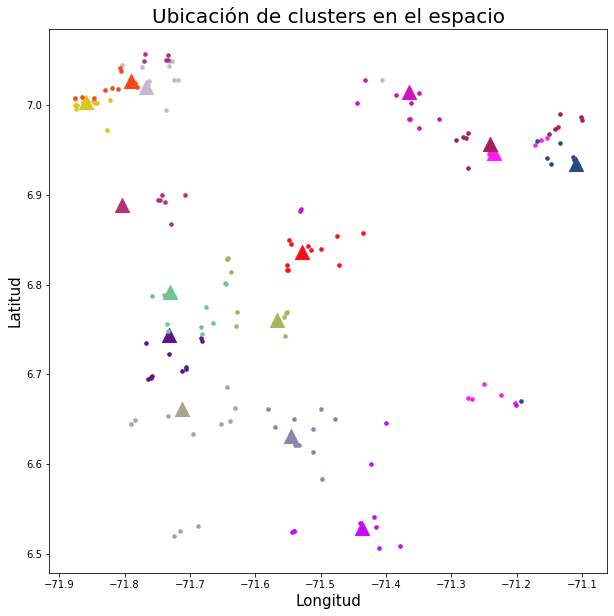

In [35]:
import matplotlib.pyplot as plt

# Imprimir los resultados
print(f'Distancia total: {mejorCosto}')
print('\n')
for medioidAct in list(mejorDictAsign.keys()):
  print(f'Coords cluster: {round(medioidAct[0], 3)}, {round(medioidAct[1], 3)}')

from matplotlib import markers
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

for medioidAct in list(mejorDictAsign.keys()):
  tuplaColor = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
  plt.scatter(medioidAct[1], medioidAct[0], color = tuplaColor, marker = "^", s = 200)
  for posiFinca in mejorDictAsign[medioidAct][1]:
    plt.scatter(ubFincas[posiFinca][1], ubFincas[posiFinca][0], color = tuplaColor, marker = ".", s = 50)

print('\n')
plt.xlabel('Longitud', fontsize = 15)
plt.ylabel('Latitud', fontsize = 15)
plt.title('Ubicación de clusters en el espacio', fontsize = 20)
plt.show()

### Gráfica Suma de Errores [Distancias]

Costo actual: 4512.7423, Mejor costo encontrado: 3947.6731 


Costo actual: 4136.8572, Mejor costo encontrado: 2704.1016 


Costo actual: 2565.1961, Mejor costo encontrado: 2057.442 


Costo actual: 2937.7676, Mejor costo encontrado: 2028.84 


Costo actual: 4145.9784, Mejor costo encontrado: 1924.2336 


Costo actual: 2485.9446, Mejor costo encontrado: 1672.8908 


Costo actual: 2115.2508, Mejor costo encontrado: 1460.1018 


Costo actual: 2653.769, Mejor costo encontrado: 1450.0287 


Costo actual: 2463.3038, Mejor costo encontrado: 1468.3678 


Costo actual: 2436.7534, Mejor costo encontrado: 1358.9944 


Costo actual: 2068.9722, Mejor costo encontrado: 1208.2296 


Costo actual: 2118.0732, Mejor costo encontrado: 1186.9752 


Costo actual: 1320.3282, Mejor costo encontrado: 1206.9079 


Costo actual: 1467.8921, Mejor costo encontrado: 1181.9693 


Costo actual: 1397.4233, Mejor costo encontrado: 1085.6837 


Costo actual: 1502.7351, Mejor costo encontrado: 939.6027 


Costo actual:

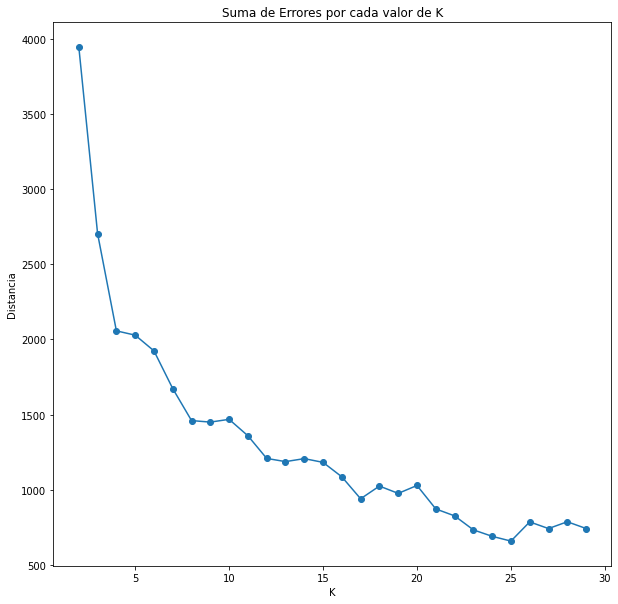

In [36]:
errores = []
k = 30
# Definir la cantidad de clusters
for K in range(2, k):
  # =================================================================== #
  #============================ FASE BUILD ============================ #
  # =================================================================== #
  # Definir los medioids iniciales
  medioidsIniciales = [] # Asignar de forma aleatoria los K medioids a fincas existentes
  dictAsignFincasMedioids = {} # Guarda las fincas asignadas a cada medioid
  listaRand = random.sample(range(n), K)
  for aleAct in listaRand:
    medioidsIniciales.append(ubFincas[aleAct])
  # Calcular distancia (disimilaridad) entre cada finca y los medioids iniciales
  dictDistFincasMedioids, dictAsignFincasMedioids = disimilaridadFincaMedioids(ubFincas, medioidsIniciales)
  # Asignar cada finca al medioid más cercano y calcular el costo (distancia) total
  dictAsignFincasMedioids = asignarFincasMedioid(ubFincas, medioidsIniciales, dictDistFincasMedioids, dictAsignFincasMedioids)
  # Si un medioid se queda sin fincas se elimina
  dictAsignFincasMedioids = eliminarMedioid(dictAsignFincasMedioids)
  # Calcular el costo total inicial de asignación
  mejorCosto = costoTotal(dictAsignFincasMedioids)
  mejorDictDist = copy.deepcopy(dictDistFincasMedioids)
  mejorDictAsign = copy.deepcopy(dictAsignFincasMedioids)


  # =================================================================== #
  # ============================ FASE SWAP ============================ #
  # =================================================================== #

  iterMax = 1000
  i = 0

  while i < iterMax:

    # Seleccionar k puntos no-medioids, convertirlos en medioids y devolver los anteriores a fincas corrientes
    dictAsignFincasMedioidsAct = swapFunction(ubFincas, mejorDictAsign)
    # Calcular distancia (disimilaridad) entre cada finca y los medioids actuales
    medioidsActuales = list(dictAsignFincasMedioidsAct.keys())
    dictDistFincasMedioids,  dictAsignFincasMedioids = disimilaridadFincaMedioids(ubFincas, medioidsActuales)
    # Asignar cada finca al medioid más cercano y calcular el costo (distancia) total
    dictAsignFincasMedioids = asignarFincasMedioid(ubFincas, medioidsActuales, dictDistFincasMedioids, dictAsignFincasMedioids)
    # Si un medioid se queda sin fincas se elimina
    dictAsignFincasMedioids = eliminarMedioid(dictAsignFincasMedioids)
    # Calcular el costo total actual de asignación
    costoActual = costoTotal(dictAsignFincasMedioids)
    if costoActual < mejorCosto:
      mejorCosto = costoActual
      mejorDictDist = copy.deepcopy(dictDistFincasMedioids)
      mejorDictAsign = copy.deepcopy(dictAsignFincasMedioids)
    i += 1
  print(f'Costo actual: {round(costoActual, 4)}, Mejor costo encontrado: {round(mejorCosto, 4)} ')
  # Guardar la suma de errores (distancias) por cada número de clusters K
  errores.append(mejorCosto)
  print('\n')

# Graficar
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
plt.scatter([i for i in range(2, k)], errores)
plt.plot([i for i in range(2, k)], errores)
plt.xlabel('K')
plt.ylabel('Distancia')
plt.title('Suma de Errores por cada valor de K')
plt.show()

### Gráfica Coeficientes de Silhouette

K: 2, Costo actual: 4710.8934, Mejor costo encontrado: 3889.2272 


K: 3, Costo actual: 3689.125, Mejor costo encontrado: 2721.5471 


K: 4, Costo actual: 2617.1076, Mejor costo encontrado: 2050.9499 


K: 5, Costo actual: 2997.8179, Mejor costo encontrado: 2060.6958 


K: 6, Costo actual: 2059.0112, Mejor costo encontrado: 1843.5153 


K: 7, Costo actual: 2087.2511, Mejor costo encontrado: 1594.8602 


K: 8, Costo actual: 1907.8759, Mejor costo encontrado: 1458.2495 


K: 9, Costo actual: 2934.4545, Mejor costo encontrado: 1350.9086 


K: 10, Costo actual: 2585.9114, Mejor costo encontrado: 1459.4895 


K: 11, Costo actual: 2067.7785, Mejor costo encontrado: 1354.6262 


K: 12, Costo actual: 2003.0895, Mejor costo encontrado: 1243.033 


K: 13, Costo actual: 1922.7075, Mejor costo encontrado: 1227.9222 


K: 14, Costo actual: 1517.0811, Mejor costo encontrado: 1197.9808 


K: 15, Costo actual: 1381.2831, Mejor costo encontrado: 1175.4243 


K: 16, Costo actual: 1665.3394, Mejor costo 

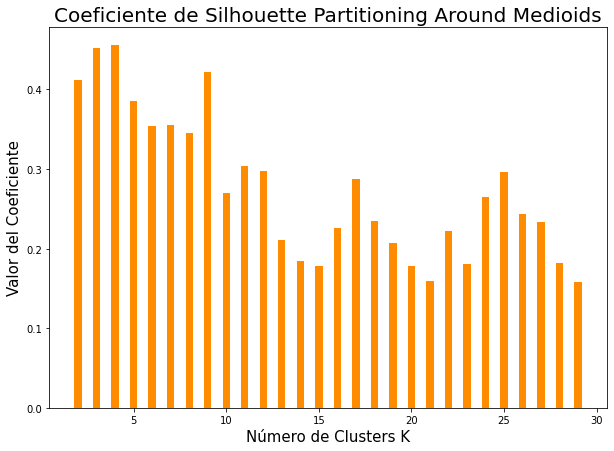

In [37]:
silhouette = []
k = 30
# Definir la cantidad de clusters
for K in range(2, k):
  # =================================================================== #
  #============================ FASE BUILD ============================ #
  # =================================================================== #
  # Definir los medioids iniciales
  medioidsIniciales = [] # Asignar de forma aleatoria los K medioids a fincas existentes
  dictAsignFincasMedioids = {} # Guarda las fincas asignadas a cada medioid
  listaRand = random.sample(range(n), K)
  for aleAct in listaRand:
    medioidsIniciales.append(ubFincas[aleAct])
  # Calcular distancia (disimilaridad) entre cada finca y los medioids iniciales
  dictDistFincasMedioids, dictAsignFincasMedioids = disimilaridadFincaMedioids(ubFincas, medioidsIniciales)
  # Asignar cada finca al medioid más cercano y calcular el costo (distancia) total
  dictAsignFincasMedioids = asignarFincasMedioid(ubFincas, medioidsIniciales, dictDistFincasMedioids, dictAsignFincasMedioids)
  # Si un medioid se queda sin fincas se elimina
  dictAsignFincasMedioids = eliminarMedioid(dictAsignFincasMedioids)
  # Calcular el costo total inicial de asignación
  mejorCosto = costoTotal(dictAsignFincasMedioids)
  mejorDictDist = copy.deepcopy(dictDistFincasMedioids)
  mejorDictAsign = copy.deepcopy(dictAsignFincasMedioids)


  # =================================================================== #
  # ============================ FASE SWAP ============================ #
  # =================================================================== #

  iterMax = 1000
  i = 0

  while i < iterMax:

    # Seleccionar k puntos no-medioids, convertirlos en medioids y devolver los anteriores a fincas corrientes
    dictAsignFincasMedioidsAct = swapFunction(ubFincas, mejorDictAsign)
    # Calcular distancia (disimilaridad) entre cada finca y los medioids actuales
    medioidsActuales = list(dictAsignFincasMedioidsAct.keys())
    dictDistFincasMedioids,  dictAsignFincasMedioids = disimilaridadFincaMedioids(ubFincas, medioidsActuales)
    # Asignar cada finca al medioid más cercano y calcular el costo (distancia) total
    dictAsignFincasMedioids = asignarFincasMedioid(ubFincas, medioidsActuales, dictDistFincasMedioids, dictAsignFincasMedioids)
    # Si un medioid se queda sin fincas se elimina
    dictAsignFincasMedioids = eliminarMedioid(dictAsignFincasMedioids)
    # Calcular el costo total actual de asignación
    costoActual = costoTotal(dictAsignFincasMedioids)
    if costoActual < mejorCosto:
      mejorCosto = costoActual
      mejorDictDist = copy.deepcopy(dictDistFincasMedioids)
      mejorDictAsign = copy.deepcopy(dictAsignFincasMedioids)
    i += 1
  print(f'K: {K}, Costo actual: {round(costoActual, 4)}, Mejor costo encontrado: {round(mejorCosto, 4)} ')
  print('\n')

  # Vector de cohesiones
  vectA = cohesion(mejorDictAsign)
  # Vetor de separaciones
  vectB = separacion(mejorDictAsign)
  # Coeficiente de Silhouette por cada finca
  coefSilhouFincas = []
  suma = 0
  for fink in range(len(vectA)):
    a = vectA[fink][1]
    b = vectB[fink][1]
    c_i = (b - a) / max(a, b)
    coefSilhouFincas.append(c_i)
  # Coeficiente de Silhouette de la iteración actual
  silhouette.append((sum(coefSilhouFincas)/len(coefSilhouFincas)))

# Imprimir resultados
print('Coeficientes de silhouette:')
p = 0
for k in range(2, k):
  print(f'K = {k} -> coeficiente = {silhouette[p]}')
  p += 1
print('\n')

je = 0
for a in silhouette:
  if a > 0.5:
    je += 1
print('Porcentaje de clusters que superan el 5%: ', je/len(silhouette))
print('\n')

k = 30
# Gráfica del Coeficiente para cada K
ks = [a for a in range(2, k)]
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(7)
plt.bar(ks, silhouette, color ='darkorange', width = 0.4)
plt.xlabel('Número de Clusters K', fontsize = 15)
plt.ylabel('Valor del Coeficiente', fontsize = 15)
plt.title('Coeficiente de Silhouette Partitioning Around Medioids', fontsize = 20)
plt.show()